In [34]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer


In [35]:
ticker = 'MSFT'
googleSent = pd.read_csv('/home/simone/Desktop/NLFF/GoogleNL/JSON_dataset/'+str(ticker)+'_googleSentimentJSON.csv', sep=';', names=['DATE','GoogleSentiment'])
googleSent = googleSent.sort_values(by=['DATE'])
googleSent = googleSent.reset_index(drop=True)
googleSent.head()

,DATE,GoogleSentiment
0,2017-05-22 00:46:00,"""{""entities"": [{""name"": ""businesses"", ""salien..."
1,2017-05-22 03:53:19,"""{""entities"": [{""name"": ""Big Tech's Not-So"", ..."
2,2017-05-22 04:12:29,"""{""entities"": [{""name"": ""jobs"", ""salience"": 0..."
3,2017-05-22 11:35:00,"""{""entities"": [{""name"": ""smartphone killer"", ..."
4,2017-05-22 13:06:51,"""{""entities"": [{""name"": ""Threat"", ""salience"":..."


In [36]:
porter_stemmer = PorterStemmer()

for i, row in googleSent.iterrows():
    a = json.loads(googleSent['GoogleSentiment'][i][2:-1])
    for ent in a['entities']:
        ent['name'] = porter_stemmer.stem(ent['name'])
    googleSent['GoogleSentiment'].at[i] = a 

In [37]:
googleSent['GoogleSentiment'][0]

{'entities': [{'name': 'busi',
   'salience': 0.5081738829612732,
   'sentiment': {'magnitude': 0.30000001192092896,
    'score': 0.10000000149011612},
   'type': 3,
   'mentions': [{'text': {'content': 'businesses', 'begin_offset': 73},
     'type': 2,
     'sentiment': {'magnitude': 0.0, 'score': 0.0}}]},
  {'name': 'look',
   'salience': 0.20836080610752106,
   'sentiment': {'magnitude': 0.0, 'score': 0.0},
   'type': 7,
   'mentions': [{'text': {'content': 'look', 'begin_offset': 10},
     'type': 2,
     'sentiment': {'magnitude': 0.0, 'score': 0.0}}]},
  {'name': 'tool',
   'salience': 0.09848238527774811,
   'sentiment': {'magnitude': 0.0, 'score': 0.0},
   'type': 7,
   'mentions': [{'text': {'content': 'tools', 'begin_offset': 22},
     'type': 2,
     'sentiment': {'magnitude': 0.0, 'score': 0.0}}]},
  {'name': 'busi',
   'salience': 0.07424759864807129,
   'sentiment': {'magnitude': 0.0, 'score': 0.0},
   'type': 7,
   'mentions': [{'text': {'content': 'business', 'begin_off

In [38]:
entities = {}

for i, row in googleSent.iterrows():
    entJ = googleSent['GoogleSentiment'][i]
    for ent in entJ['entities']:
        if ent['name'] in entities:
            entities[ent['name']] +=1
        else:
            entities[ent['name']] =1

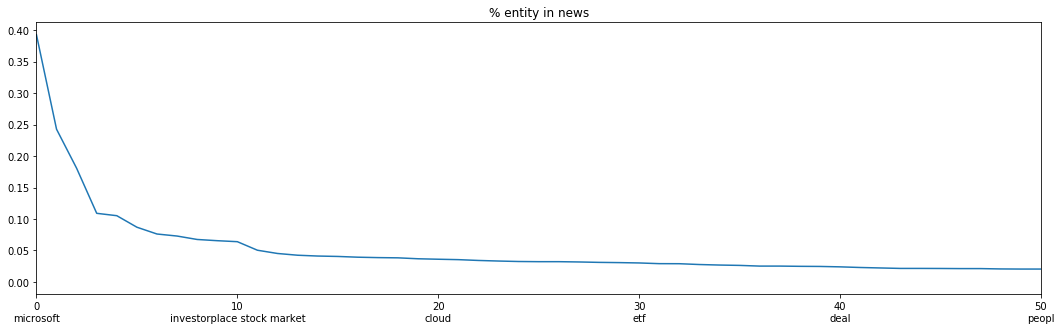

In [39]:
ent = entities.items()
ent = sorted(ent, key=lambda kv: kv[1], reverse=True)
x = [entity[0] for entity in ent]
y = [entity[1] for entity in ent]
y = [item/len(googleSent) for item in y]
plt.figure(figsize=(18,5))
plt.plot(y)
plt.xlim((0, 50)) 
plt.title('% entity in news')
locs, labels = plt.xticks()  
plt.xticks(locs, [str(int(l))+'\n'+str(x[int(l)]) for l in locs])
plt.show()


In [40]:
threshhold = 30
most_common = x[0:threshhold]
print('Most common entities:\n'+str(most_common))
print('\n\nWe are ignoring the others '+str(len(x)-threshhold)+' entities that appear less than '+"{:1.1f}".format(y[threshhold]*100)+' % of times')
print('We are ignoring '+"{:1.1f}".format((1 - sum(y[:threshhold])/sum(y) )*100)+'% of the mentions')

Most common entities:
['microsoft', 'stock', 'compani', 'share', 'appl', 'nasdaq', 'amazon', 'googl', 'earn', 'investor', 'investorplace stock market', 'market', 'facebook', 'posit', 'world', 'game', 'revenu', 'busi', 'microsoft corpor', 'amp trading tip', 'cloud', 'u.s.', 'technolog', 'growth', 'result', 'thing', 'amp', 'analyst', 'report', 'ibm']


We are ignoring the others 25112 entities that appear less than 3.0 % of times
We are ignoring 81.3% of the mentions


In [ ]:
# googleSent['entSentVec'] = ''
# for i, row in googleSent.iterrows():
#     vec = [0]*(len(most_common)*3+2) #for each entity: salience, magnitude and sentiment + total sentiment & magnitude
#     entJ = googleSent['GoogleSentiment'][i]
#     totSent = 0
#     totMagn = 0
#     for ent in entJ['entities']:
#         totSent += ent['sentiment']['score']
#         totMagn += ent['sentiment']['magnitude']
        
#         if ent['name'] in most_common:
#             offset = most_common.index(ent['name'])*3
#             vec[offset] = ent['salience']
#             vec[offset+1] = ent['sentiment']['magnitude']            
#             vec[offset+2] = ent['sentiment']['score']
#     vec[-2] = totMagn
#     vec[-1] = totSent
#     googleSent['entSentVec'].at[i] = vec
    
# googleSent.to_csv('SentimentSingleNews/'+str(ticker)+'_googleSentVector.csv')

In [41]:
 #for each entity: salience, magnitude, sentiment and count of # times of mention + total sentiment & magnitude
features_names = [w+'_sa' for w in most_common]
features_names += [w+'_se' for w in most_common]
features_names += [w+'_ma' for w in most_common]
features_names += [w+'_co' for w in most_common]
features_names +=['tot_se','tot_ma']

for feature_name in features_names:
    googleSent[feature_name] = '' 

for i, row in googleSent.iterrows():
    if(i%1000 == 0):
        print(i)
    features = {feature_name: 0 for feature_name in features_names}

    entJ = googleSent['GoogleSentiment'][i]
    for ent in entJ['entities']:
        features['tot_se'] += ent['sentiment']['score']
        features['tot_ma'] += ent['sentiment']['magnitude']
        if ent['name'] in most_common:
            features[str(ent['name'])+'_ma'] = ent['sentiment']['magnitude'] 
            features[str(ent['name'])+'_se'] = ent['sentiment']['score']
            features[str(ent['name'])+'_sa'] = ent['sentiment']['magnitude'] 
            features[str(ent['name'])+'_co'] = 1 
    for f in features.keys():
        googleSent.at[i,f] = features[f]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [42]:
googleSent.to_csv('SentimentSingleNews/'+str(ticker)+'_googleSentVector.csv')

In [ ]:
len(googleSent.columns)